In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np

In [2]:
TRAIN_FILE   = "train_set_10.4k.csv" 
FEATURES_CSV = "feature_sets_large_study/pls_representative_features.csv"
HOLDOUT_FILE = "test_set_2.6k.csv"                        

In [3]:
feature_list = pd.read_csv(FEATURES_CSV)["feature"].astype(str).tolist()

In [4]:
df_train = pd.read_csv(TRAIN_FILE)
y_train = df_train["pathogenicity_label"].astype(int)
X_train_raw0 = df_train.drop(columns=["pathogenicity_label"])

In [5]:
# keep only columns present in both the file and feature list (preserve order from list)
keep_cols_train = [c for c in feature_list if c in X_train_raw0.columns]
missing_train   = sorted(set(feature_list) - set(keep_cols_train))
if missing_train:
    print(f"[Info] {len(missing_train)} features from list not found in TRAIN (e.g. {missing_train[:6]})")

X_train_raw = X_train_raw0.loc[:, keep_cols_train].copy()

In [6]:
pre = Pipeline([("imputer", KNNImputer(n_neighbors=5, metric="nan_euclidean"))])

In [7]:
try:
    pre.set_output(transform="pandas")
except Exception:
    pass

In [8]:
pre.fit(X_train_raw, y_train)

,steps,"[('imputer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,n_neighbors,5
,weights,'uniform'
,metric,'nan_euclidean'
,copy,True
,add_indicator,False
,keep_empty_features,False


In [9]:
X_train = pre.transform(X_train_raw)
if isinstance(X_train, np.ndarray):    # make DataFrame with same column names
    X_train = pd.DataFrame(X_train, index=X_train_raw.index, columns=X_train_raw.columns)

In [10]:
df_test     = pd.read_csv(HOLDOUT_FILE)
y_test      = df_test["pathogenicity_label"].astype(int)
X_test_raw0 = df_test.drop(columns=["pathogenicity_label"])

keep_cols_test = [c for c in feature_list if c in X_test_raw0.columns]
missing_test   = sorted(set(feature_list) - set(keep_cols_test))
if missing_test:
    print(f"[Info] {len(missing_test)} features from list not found in TEST (e.g. {missing_test[:6]})")

X_test_raw = X_test_raw0.loc[:, keep_cols_test].copy()

# align TEST columns to TRAIN columns (order + any missing become NaN -> imputer handles)
X_test_raw = X_test_raw.reindex(columns=X_train_raw.columns)

# impute TEST using the TRAIN-fitted imputer
X_test = pre.transform(X_test_raw)
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, index=X_test_raw.index, columns=X_test_raw.columns)

In [11]:
print("Shapes of X_train/X_test:", X_train.shape,"/" ,X_test.shape)

Shapes of X_train/X_test: (10370, 56) / (2593, 56)


In [12]:
import sys, os
sys.path.append(os.path.abspath("/home/vincnet/projects/ml_project/streamlined_pipeline/cancer_mutation_analysis/"))  # path to the folder that contains ml_large_data/

from ml_large_data.baselines import baseline_models
from ml_large_data.metrics import compute_all_metrics, find_best_threshold_mcc
from ml_large_data.tuning import lgbm_objective, xgb_objective, catboost_objective
import optuna

In [13]:
from ml_large_data.baselines import baseline_models
models = baseline_models() if callable(baseline_models) else baseline_models

,ROC AUC,MCC,F1 Score,Balanced Accuracy,Precision,Recall
Logistic Regression,0.7635,0.3906,0.6996,0.6954,0.7050,0.6943
Bayesian NN,0.7463,0.3621,0.7016,0.6799,0.6722,0.7336
Naive Bayes,0.7270,0.3433,0.7080,0.6665,0.6448,0.7849


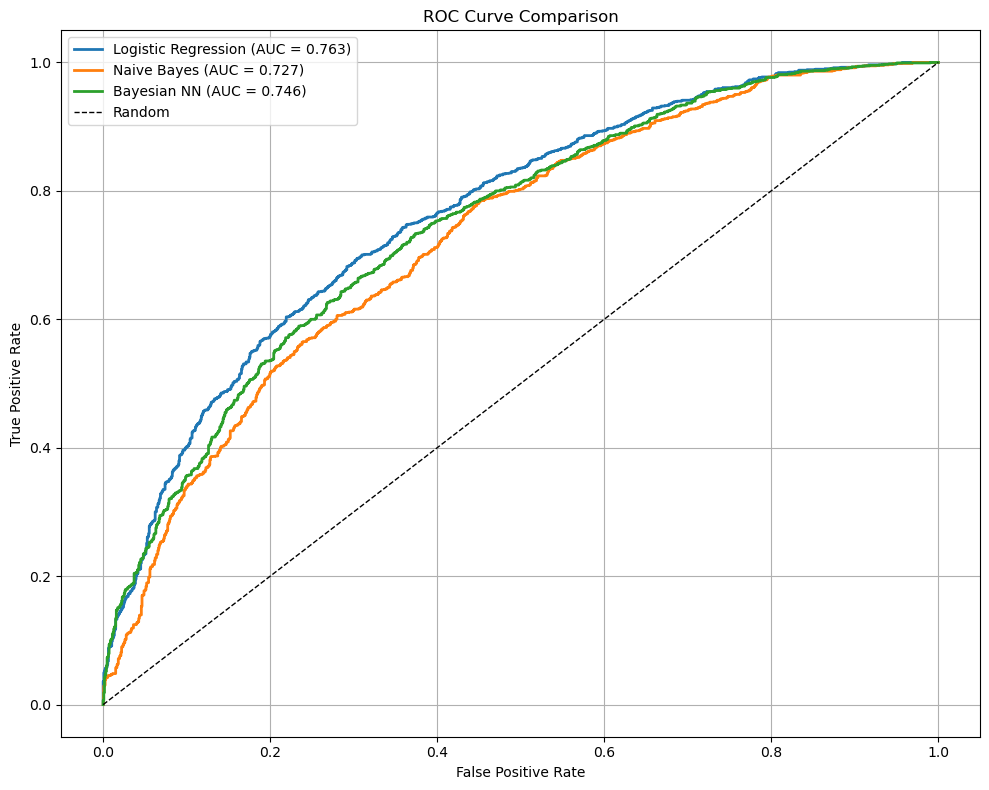

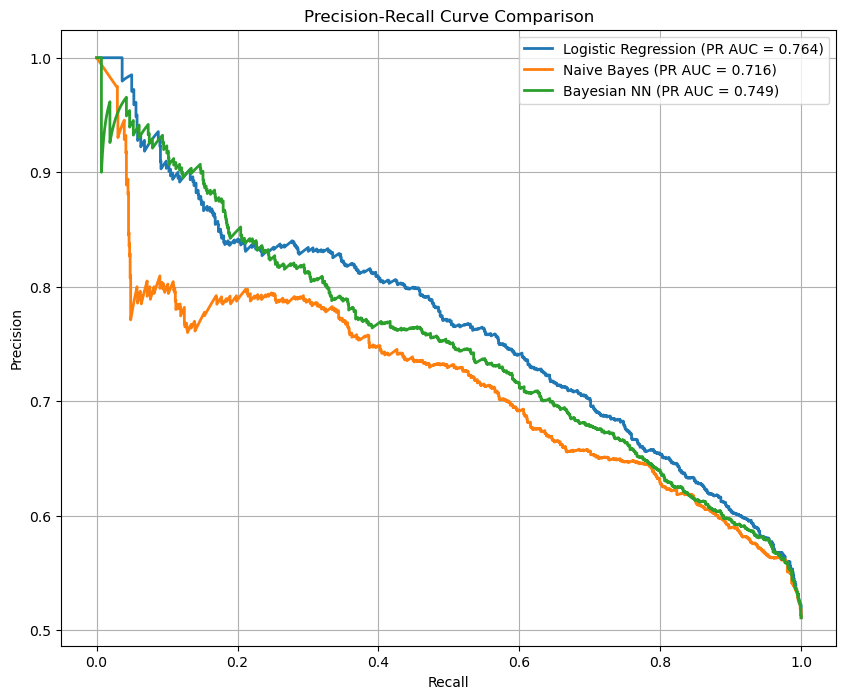

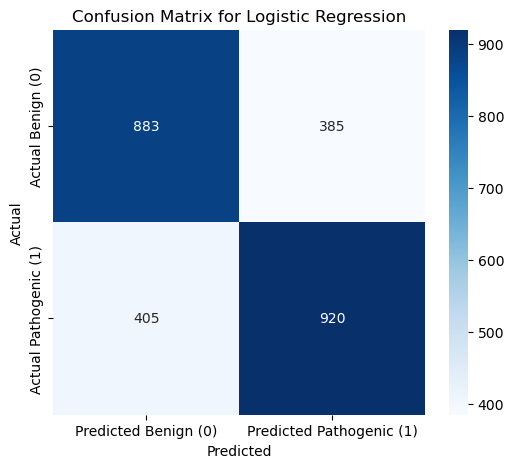

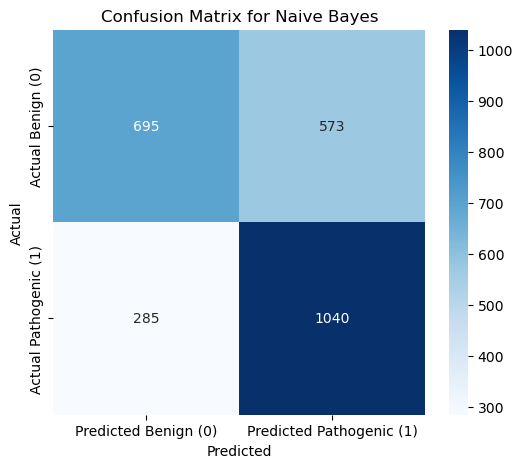

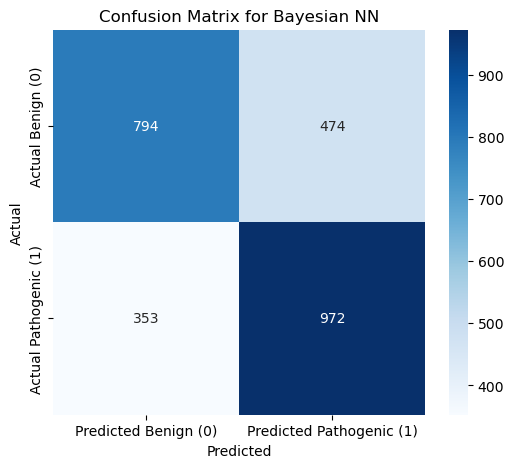

In [14]:
from ml_large_data.metrics import compute_all_metrics, find_best_threshold_mcc

results = {}
all_model_predictions_baseline = {}

for name, model in models.items():
    # fit once
    model.fit(X_train, y_train)

    # predict once (probs -> threshold -> labels)
    p = model.predict_proba(X_test)[:, 1]
    thr, _ = find_best_threshold_mcc(y_test, p)
    yhat = (p >= thr).astype(int)

    # store for metrics table
    results[name] = compute_all_metrics(y_test, yhat, p)

    # store for downstream plots (no refit later)
    all_model_predictions_baseline[name] = {'y_pred_prob': p, 'y_pred': yhat}

# metrics table
results_df = (pd.DataFrame(results).T
                [ ['ROC AUC','MCC','F1 Score','Balanced Accuracy','Precision','Recall'] ]
                .sort_values('ROC AUC', ascending=False))
display(results_df)

# plots
from ml_large_data.plots import plot_precision_recall_curves, plot_confusion_matrix_heatmap, plot_roc_curves

plot_roc_curves(all_model_predictions_baseline, y_test)
plot_precision_recall_curves(all_model_predictions_baseline, y_test)

for name, data in all_model_predictions_baseline.items():
    plot_confusion_matrix_heatmap(y_test, data['y_pred'], name)

In [15]:
import optuna
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
import pandas as pd

from ml_large_data.tuning import lgbm_objective, xgb_objective, catboost_objective
from ml_large_data.metrics import compute_all_metrics, find_best_threshold_mcc
from ml_large_data.plots import plot_precision_recall_curves, plot_confusion_matrix_heatmap, plot_roc_curves

In [ ]:
# Tunning with Optuna
N_TRIALS = 100

studies = {}

print(f"Tuning LightGBM ({N_TRIALS} trials)...")
studies["LightGBM"] = optuna.create_study(direction="maximize")
studies["LightGBM"].optimize(lambda t: lgbm_objective(t, X_train_raw, y_train, pre), n_trials=N_TRIALS)

print(f"Tuning XGBoost ({N_TRIALS} trials)...")
studies["XGBoost"] = optuna.create_study(direction="maximize")
studies["XGBoost"].optimize(lambda t: xgb_objective(t, X_train_raw, y_train, pre), n_trials=N_TRIALS)

print("Tuning CatBoost ({N_TRIALS} trials)...")
studies["CatBoost"] = optuna.create_study(direction="maximize")
studies["CatBoost"].optimize(lambda t: catboost_objective(t, X_train_raw, y_train, pre), n_trials=N_TRIALS)

for name, study in studies.items():
    print(f"\n{name} - Best AUC: {study.best_value:.4f}")
    print(f"{name} - Best params: {study.best_params}")

[I 2025-09-18 14:40:34,791] A new study created in memory with name: no-name-e40ddca5-e153-4126-9046-add744a6b277


Tuning LightGBM (100 trials)...


[I 2025-09-18 14:40:38,905] Trial 0 finished with value: 0.8426621636708719 and parameters: {'learning_rate': 0.02673347361696881, 'num_leaves': 220, 'max_depth': 8, 'lambda_l1': 0.05525558376526057, 'lambda_l2': 0.0007382481409444956, 'feature_fraction': 0.46625815046743424, 'bagging_fraction': 0.6696055862146213, 'bagging_freq': 7}. Best is trial 0 with value: 0.8426621636708719.
[I 2025-09-18 14:40:41,927] Trial 1 finished with value: 0.8317628670313721 and parameters: {'learning_rate': 0.03658354970063172, 'num_leaves': 162, 'max_depth': 4, 'lambda_l1': 6.487529438173505e-08, 'lambda_l2': 0.13261580829724803, 'feature_fraction': 0.8406093140310775, 'bagging_fraction': 0.4531291116088212, 'bagging_freq': 6}. Best is trial 0 with value: 0.8426621636708719.
[I 2025-09-18 14:40:45,557] Trial 2 finished with value: 0.8377070075546128 and parameters: {'learning_rate': 0.005065844495283382, 'num_leaves': 21, 'max_depth': 7, 'lambda_l1': 0.005024892510696442, 'lambda_l2': 1.487906537656642

Tuning XGBoost (100 trials)...


/home/vincnet/miniconda3/envs/ml-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:47:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-18 14:47:45,213] Trial 0 finished with value: 0.8435953258159354 and parameters: {'eta': 0.08531694537466804, 'max_depth': 7, 'subsample': 0.8826805412595999, 'colsample_bytree': 0.9954392920817811, 'lambda': 3.9753688318049694e-08, 'alpha': 0.0003728435056830698}. Best is trial 0 with value: 0.8435953258159354.
/home/vincnet/miniconda3/envs/ml-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:47:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-18 14:47:56,020] Trial 1 finished with value: 0.8339669160061033 and parameters: {'eta': 0.002623370748851654, 'max_depth': 7, 'subsample': 0.6086382558568044, 'c

Tuning CatBoost ({N_TRIALS} trials)...


[I 2025-09-18 15:12:29,607] Trial 0 finished with value: 0.8171355736667782 and parameters: {'learning_rate': 0.05069244766823123, 'depth': 15, 'l2_leaf_reg': 0.002278035931796966, 'random_strength': 0.00034069744258456263, 'bagging_temperature': 0.3674027482588307}. Best is trial 0 with value: 0.8171355736667782.
[I 2025-09-18 15:14:05,150] Trial 1 finished with value: 0.8443070596553905 and parameters: {'learning_rate': 0.004778336186473465, 'depth': 14, 'l2_leaf_reg': 7.190845212283182e-08, 'random_strength': 1.1856598519965624e-05, 'bagging_temperature': 0.8717537942201411}. Best is trial 1 with value: 0.8443070596553905.
[I 2025-09-18 15:15:51,274] Trial 2 finished with value: 0.844812251125749 and parameters: {'learning_rate': 0.005445345323394721, 'depth': 14, 'l2_leaf_reg': 0.00010720091254685499, 'random_strength': 0.12563616480414264, 'bagging_temperature': 0.49643703326560773}. Best is trial 2 with value: 0.844812251125749.
[I 2025-09-18 15:15:57,002] Trial 3 finished with v


LightGBM — Best AUC: 0.8544
LightGBM — Best params: {'learning_rate': 0.009533462480140606, 'num_leaves': 232, 'max_depth': 11, 'lambda_l1': 0.025789902119796024, 'lambda_l2': 1.8262166069043162e-06, 'feature_fraction': 0.43128980490779223, 'bagging_fraction': 0.8928162438040176, 'bagging_freq': 2}

XGBoost — Best AUC: 0.8549
XGBoost — Best params: {'eta': 0.012325499165779193, 'max_depth': 9, 'subsample': 0.8784691380970603, 'colsample_bytree': 0.7161519814831641, 'lambda': 9.825733812311977e-05, 'alpha': 6.0555023753247936e-05}

CatBoost — Best AUC: 0.8603
CatBoost — Best params: {'learning_rate': 0.003196213406148865, 'depth': 10, 'l2_leaf_reg': 3.498146459942054e-05, 'random_strength': 4.173453285998266e-06, 'bagging_temperature': 0.7232528962175755}


In [17]:
import json, datetime

In [ ]:
# save best params from Optuna tuning to JSON

def to_py(obj):
    if isinstance(obj, (int, float, str, bool)) or obj is None: return obj
    try: return obj.item()
    except Exception: return obj

best = {
    m: {"best_value": float(study.best_value),
        "best_params": {k: to_py(v) for k, v in study.best_params.items()}}
    for m, study in studies.items()
}

best["meta"] = {"timestamp": datetime.datetime.now().isoformat()}

with open("best_params.json", "w") as f:
    json.dump(best, f, indent=2)
print("Saved best params to best_params.json")

Saved best params to best_params.json


,ROC AUC,MCC,F1 Score,Balanced Accuracy,Precision,Recall,threshold
CatBoost,0.8625,0.5844,0.7853,0.7915,0.8248,0.7494,0.5515
LightGBM,0.8587,0.5669,0.7756,0.7827,0.8170,0.7381,0.5472
XGBoost,0.8585,0.5679,0.7815,0.7838,0.8059,0.7585,0.5330


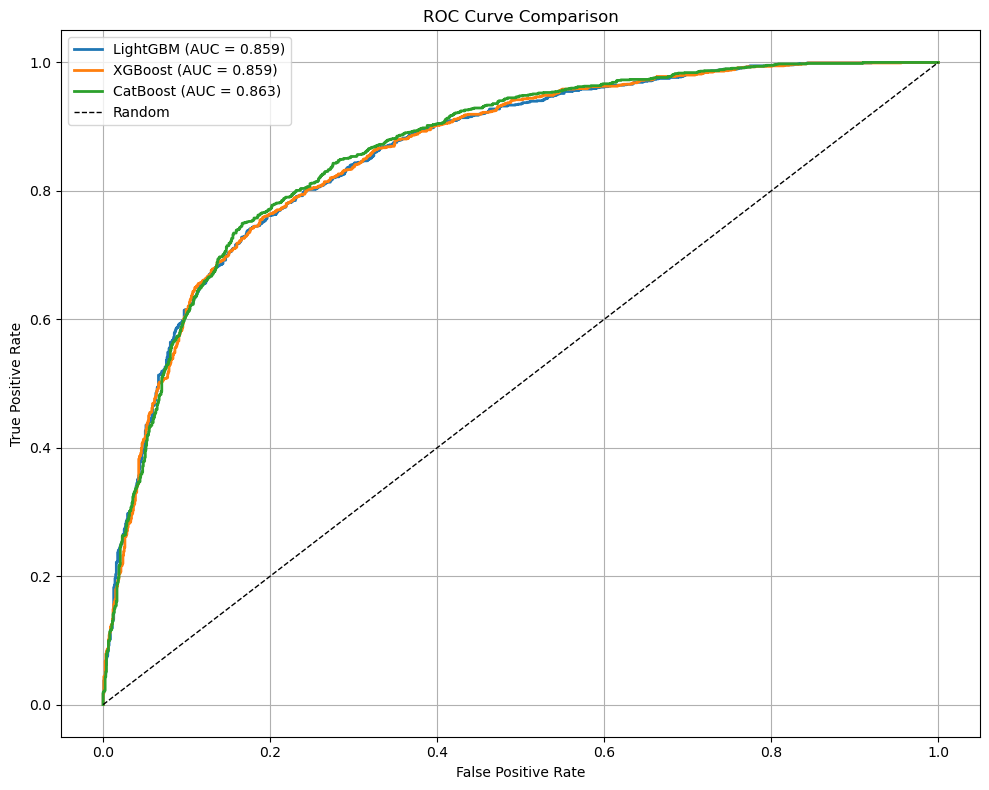

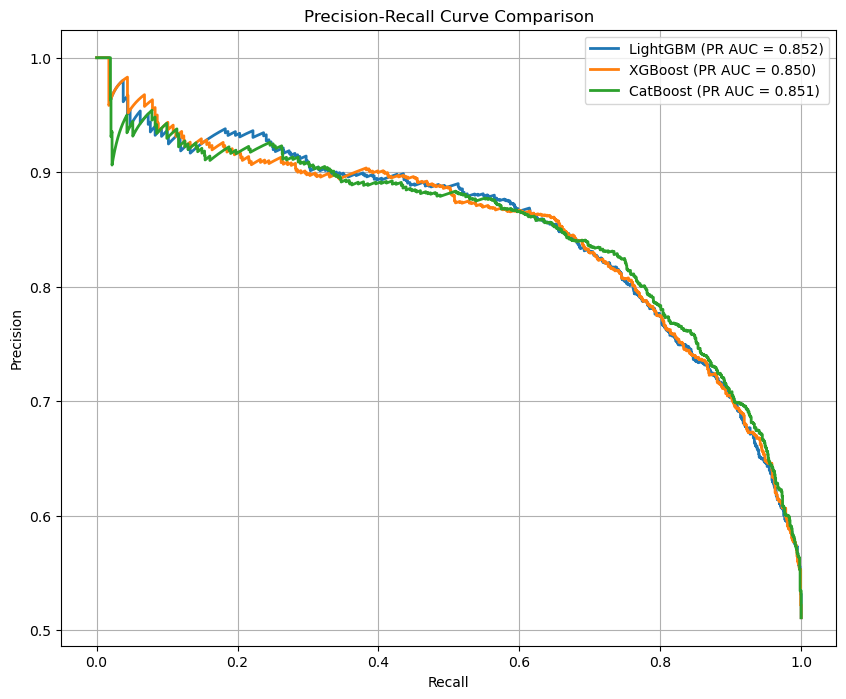

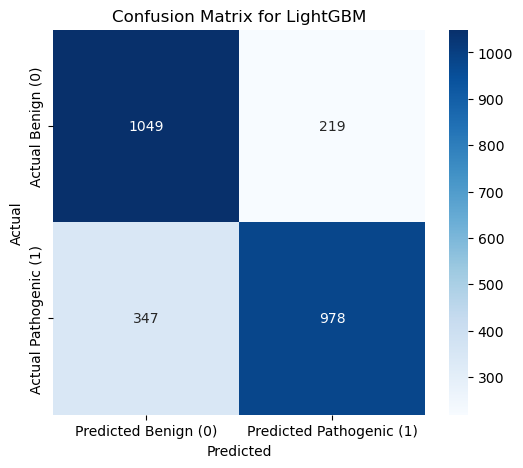

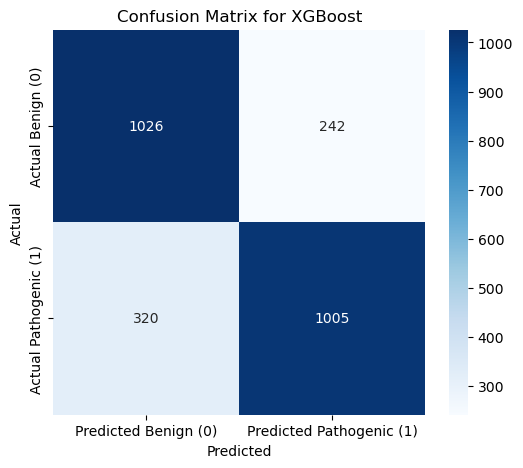

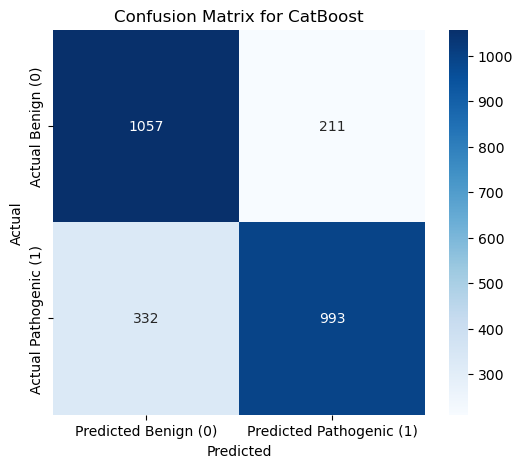

In [18]:
with open("best_params.json") as f:
    best = json.load(f)

# Fit final pipelines on TRAIN and eval on TEST
final_pipes = {}
all_model_predictions = {}
results = {}

# LightGBM final
lgb_params = {**best["LightGBM"]["best_params"],
              "objective":"binary","metric":"auc","verbosity":-1,"boosting_type":"gbdt",
              "n_estimators":1000,"random_state":42}


lgb_pipe = Pipeline([("pre", pre), ("clf", LGBMClassifier(**lgb_params))])
lgb_pipe.fit(X_train_raw, y_train)
p_lgb = lgb_pipe.predict_proba(X_test_raw)[:, 1]
thr_lgb, _ = find_best_threshold_mcc(y_test, p_lgb)
yhat_lgb = (p_lgb >= thr_lgb).astype(int)
final_pipes["LightGBM"] = lgb_pipe
all_model_predictions["LightGBM"] = {"y_pred_prob": p_lgb, "y_pred": yhat_lgb}
results["LightGBM"] = compute_all_metrics(y_test, yhat_lgb, p_lgb) | {"threshold": round(thr_lgb, 4)}

# XGBoost final
xgb_params = {**best["XGBoost"]["best_params"], "n_estimators":1000,"random_state":42}

xgb_pipe = Pipeline([("pre", pre), ("clf", xgb.XGBClassifier(**xgb_params))])
xgb_pipe.fit(X_train_raw, y_train)
p_xgb = xgb_pipe.predict_proba(X_test_raw)[:, 1]
thr_xgb, _ = find_best_threshold_mcc(y_test, p_xgb)
yhat_xgb = (p_xgb >= thr_xgb).astype(int)
final_pipes["XGBoost"] = xgb_pipe
all_model_predictions["XGBoost"] = {"y_pred_prob": p_xgb, "y_pred": yhat_xgb}
results["XGBoost"] = compute_all_metrics(y_test, yhat_xgb, p_xgb) | {"threshold": round(thr_xgb, 4)}

# CatBoost final
cb_params  = {**best["CatBoost"]["best_params"], "random_state":42,"verbose":0}

cb_pipe = Pipeline([("pre", pre), ("clf", CatBoostClassifier(**cb_params))])
cb_pipe.fit(X_train_raw, y_train)
p_cb = cb_pipe.predict_proba(X_test_raw)[:, 1]
thr_cb, _ = find_best_threshold_mcc(y_test, p_cb)
yhat_cb = (p_cb >= thr_cb).astype(int)
final_pipes["CatBoost"] = cb_pipe
all_model_predictions["CatBoost"] = {"y_pred_prob": p_cb, "y_pred": yhat_cb}
results["CatBoost"] = compute_all_metrics(y_test, yhat_cb, p_cb) | {"threshold": round(thr_cb, 4)}

# metrics table and plots
results_df = (
    pd.DataFrame(results)
      .T[["ROC AUC","MCC","F1 Score","Balanced Accuracy","Precision","Recall","threshold"]]
      .sort_values("ROC AUC", ascending=False)
)
display(results_df)

# ROC curves
plot_roc_curves(all_model_predictions, y_test)

# Precision–Recall curves
plot_precision_recall_curves(all_model_predictions, y_test)

# Confusion matrices
for name, data in all_model_predictions.items():
    plot_confusion_matrix_heatmap(y_test, data["y_pred"], f"{name}")

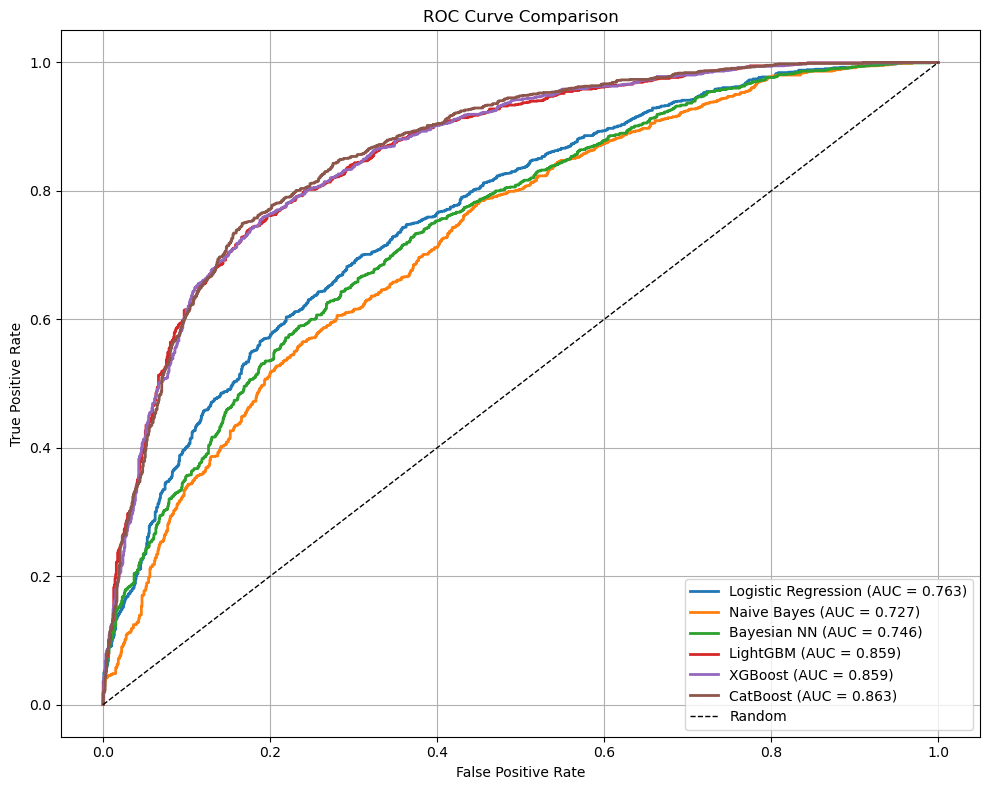

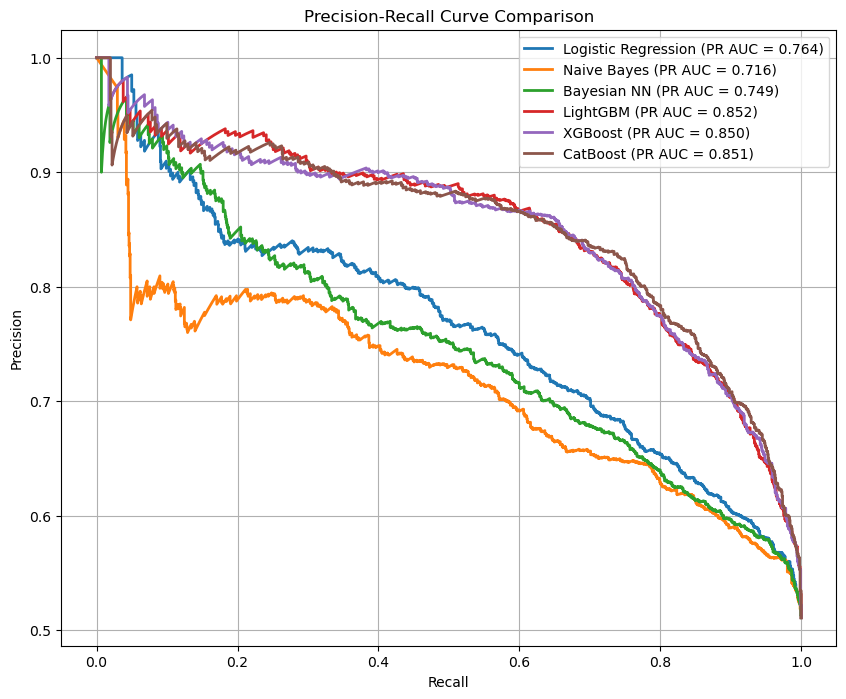

In [51]:
all_model_predictions_merged = {
    **all_model_predictions_baseline,
    **all_model_predictions
}

plot_roc_curves(all_model_predictions_merged, y_test)
plot_precision_recall_curves(all_model_predictions_merged, y_test)

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch

from ml_large_data.metrics import find_best_threshold_mcc

def _is_bnn(model):
    """
    Heuristic: our Bayes-by-Backprop wrapper exposes `. _net` and usually `.device_`.
    """
    return hasattr(model, "_net")

def summarize_bnn_uncertainty(model, X, y_true=None, n_samples=200):
    """
    Returns dict with arrays for p_mean, p_std, entropy, expected_entropy, mutual_info, and y_true.
    Also returns 'samples' as (S, N) MC predictive probs.
    Works for:
      - BNN models with model._net(X, sample=True) -> logits
      - Any sklearn-like model with .predict_proba (deterministic fallback)
    """
    # Ensure 2D float32 ndarray
    if hasattr(X, "values"):
        X_np = X.values.astype(np.float32)
    else:
        X_np = np.asarray(X, dtype=np.float32)
    N = X_np.shape[0]
    eps = 1e-12

    if _is_bnn(model):
        dev = torch.device(getattr(model, "device_", None) or ('cuda' if torch.cuda.is_available() else 'cpu'))
        model._net.eval()
        Xt = torch.from_numpy(X_np).to(dev)
        outs = []
        with torch.no_grad():
            for _ in range(n_samples):
                logits, _, _ = model._net(Xt, sample=True)  # (N, 1) or (N,)
                p = torch.sigmoid(logits).flatten().cpu().numpy()
                outs.append(p)
        samples = np.stack(outs, axis=0)  # (S, N)
    else:
        # Fallback: repeat deterministic probabilities
        p = model.predict_proba(X_np)[:, 1]
        samples = np.repeat(p[None, :], n_samples, axis=0)

    p_mean = samples.mean(axis=0)
    p_std  = samples.std(axis=0)
    # predictive entropy H[p(y|x)]
    H_pred = -(p_mean*np.log(p_mean+eps) + (1-p_mean)*np.log(1-p_mean+eps))
    # expected entropy E_q[H[p(y|x,w)]]
    H_exp  = np.mean(-(samples*np.log(samples+eps) + (1-samples)*np.log(1-samples+eps)), axis=0)
    MI     = H_pred - H_exp  # Epistemic uncertainty

    out = {
        "p_mean": p_mean,
        "p_std": p_std,
        "entropy": H_pred,
        "expected_entropy": H_exp,
        "mutual_info": MI,
        "samples": samples
    }
    if y_true is not None:
        out["y_true"] = np.asarray(y_true).astype(int)
    return out

def bnn_single_point_report(model, x_row, *, n_samples=1000, threshold=0.5, show_plot=True):
    """
    x_row: shape (1, n_features) — e.g. X_test.iloc[[i]]
    Returns dict with p_samples, p_mean, p_std, entropy, expected_entropy, mutual_info, conf, y_hat, ci_95.
    """
    # Prepare a 2D row
    if hasattr(x_row, "values"):
        x_np = x_row.values.astype(np.float32)
    else:
        x_np = np.asarray(x_row, dtype=np.float32)
    if x_np.ndim == 1:
        x_np = x_np[None, :]

    # Collect predictive samples
    if _is_bnn(model):
        dev = torch.device(getattr(model, "device_", None) or ('cuda' if torch.cuda.is_available() else 'cpu'))
        model._net.eval()
        Xt = torch.from_numpy(x_np).to(dev)
        outs = []
        with torch.no_grad():
            for _ in range(n_samples):
                logits, _, _ = model._net(Xt, sample=True)
                outs.append(torch.sigmoid(logits).cpu().numpy().flatten()[0])
        p_samples = np.array(outs)
    else:
        p = model.predict_proba(x_np)[:, 1]
        p_samples = np.repeat(p, n_samples)

    eps = 1e-12
    p_mean = float(p_samples.mean())
    p_std  = float(p_samples.std())
    H_pred = float(-(p_mean*np.log(p_mean+eps) + (1-p_mean)*np.log(1-p_mean+eps)))
    H_exp  = float(np.mean(-(p_samples*np.log(p_samples+eps) + (1-p_samples)*np.log(1-p_samples+eps))))
    MI     = float(H_pred - H_exp)
    conf   = float(max(p_mean, 1-p_mean))
    y_hat  = int(p_mean >= threshold)
    lo, hi = np.percentile(p_samples, [2.5, 97.5])

    if show_plot:
        plt.figure(figsize=(6,4))
        plt.hist(p_samples, bins=25, alpha=0.85, density=True)
        plt.axvline(p_mean, linestyle='--', linewidth=2, label=f"mean={p_mean:.3f}")
        if threshold is not None:
            plt.axvline(threshold, linestyle=':', linewidth=2, label=f"thr={threshold:.2f}")
        plt.axvspan(lo, hi, alpha=0.15, label=f"95% CI [{lo:.3f}, {hi:.3f}]")
        plt.xlabel("p(y=1 | x, w)"); plt.ylabel("density"); plt.title("BNN predictive distribution (single x)")
        plt.legend(); plt.tight_layout(); plt.show()

    return {
        "p_samples": p_samples,
        "p_mean": p_mean,
        "p_std": p_std,
        "entropy": H_pred,
        "expected_entropy": H_exp,
        "mutual_info": MI,
        "confidence": conf,
        "y_hat": y_hat,
        "ci_95": (float(lo), float(hi)),
    }

def triage_uncertainty_table(model, X, y_true, *, thr, n_samples=200,
                             mi_hi=None, mi_mid=None, margin_min=0.02):
    """
    Traffic-light labels via MC predictive uncertainty:
      RED:     95% CI crosses thr OR MI >= mi_hi
      YELLOW:  otherwise, MI >= mi_mid OR (distance of CI to thr < margin_min)
      GREEN:   everything else
    If mi_hi/mi_mid are None, picked from MI quantiles (0.80/0.50).
    """
    summ = summarize_bnn_uncertainty(model, X, y_true, n_samples=n_samples)
    p_mean = summ["p_mean"]; p_std = summ["p_std"]
    mi = summ["mutual_info"]; ent = summ["entropy"]
    y_true = np.asarray(summ.get("y_true", np.full(len(p_mean), np.nan))).astype(int)

    samples = summ["samples"]           # (S, N)
    ci_lo = np.percentile(samples, 2.5, axis=0)
    ci_hi = np.percentile(samples, 97.5, axis=0)

    crosses = (ci_lo < thr) & (ci_hi > thr)
    dist_to_thr = np.minimum(np.abs(ci_hi - thr), np.abs(ci_lo - thr))

    if mi_hi is None:  mi_hi  = float(np.quantile(mi, 0.80))
    if mi_mid is None: mi_mid = float(np.quantile(mi, 0.50))

    label = np.full(len(p_mean), "GREEN", dtype=object)
    label[(crosses) | (mi >= mi_hi)] = "RED"
    label[(label=="GREEN") & ((mi >= mi_mid) | (dist_to_thr < margin_min))] = "YELLOW"

    abstain = (label == "RED")

    idx = getattr(X, "index", None)
    df = pd.DataFrame({
        "p_mean": p_mean,
        "p_std": p_std,
        "entropy": ent,
        "mutual_info": mi,
        "ci_lo": ci_lo,
        "ci_hi": ci_hi,
        "crosses_thr": crosses,
        "dist_CI_to_thr": dist_to_thr,
        "y_true": y_true,
        "pred@thr": (p_mean >= thr).astype(int),
        "label": label,
        "abstain": abstain
    }, index=idx)

    # Sort: RED (high MI first, then small distance), then YELLOW, then GREEN
    label_rank = df["label"].map({"RED":0, "YELLOW":1, "GREEN":2})
    df = (df.assign(_rank=label_rank)
            .sort_values(by=["_rank","mutual_info","dist_CI_to_thr"],
                         ascending=[True, False, True])
            .drop(columns="_rank"))
    return df, {"mi_hi": mi_hi, "mi_mid": mi_mid, "thr": thr, "margin_min": margin_min}

# Locate trained BNN from the fitted 'models' dict
def _get_bnn(models_dict):
    # Try common keys; else fuzzy match
    keys = list(models_dict.keys())
    for k in keys:
        if k.lower() in {"bayesian nn", "bayesian neural network", "bnn"}:
            return k, models_dict[k]
    for k in keys:
        if "bayes" in k.lower():
            return k, models_dict[k]
    raise KeyError("Could not find a Bayesian NN in `models` - available keys: " + ", ".join(keys))

bnn_name, bnn_model = _get_bnn(models)

# Compute the operating threshold for the BNN (reuse existing if available)
try:
    p_bnn_test = bnn_model.predict_proba(np.asarray(X_test, dtype=np.float32))[:, 1]
    thr_bnn, _ = find_best_threshold_mcc(y_test, p_bnn_test)
except Exception:
    # fall back to 0.5 if thresholding helper not available
    thr_bnn = 0.5

print(f"BNN model key: {bnn_name} | chosen threshold: {thr_bnn:.3f}")

BNN model key: Bayesian NN | chosen threshold: 0.508


In [63]:
def find_bnn_key(d):
    for k in d.keys():
        if k.lower() in {"bayesian nn", "bayesian neural network", "bnn"}:
            return k
    for k in d.keys():
        if "bayes" in k.lower():
            return k
    raise KeyError(f"No BNN-like key in: {list(d.keys())}")

bnn_key = find_bnn_key(models)
bnn_model = models[bnn_key]

# Use stored test probs if present; otherwise compute once
if bnn_key in all_model_predictions_baseline and "y_pred_prob" in all_model_predictions_baseline[bnn_key]:
    p_bnn_test = all_model_predictions_baseline[bnn_key]["y_pred_prob"]
else:
    p_bnn_test = bnn_model.predict_proba(np.asarray(X_test, dtype=np.float32))[:, 1]

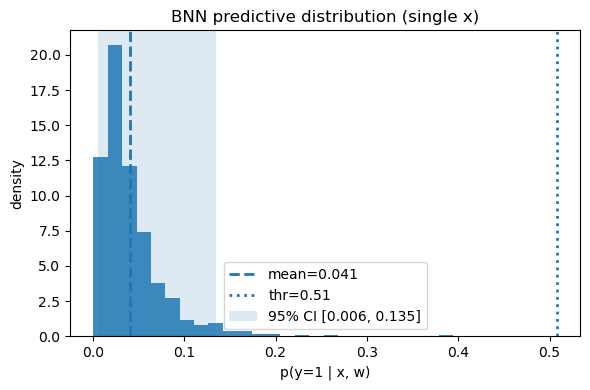

{'index': 2004, 'p_mean': 0.04071544110774994, 'p_std': 0.03484835848212242, 'entropy': 0.1702112310360091, 'mutual_info': 0.012175803704084665, '95%_CI': (0.005982701666653156, 0.1346884325146675), 'y_hat@thr': 0, 'y_true': 1}


In [96]:
i = 2004
rep = bnn_single_point_report(bnn_model, X_test.iloc[[i]], n_samples=1000, threshold=thr_bnn, show_plot=True)
print({
    "index": i,
    "p_mean": rep["p_mean"],
    "p_std": rep["p_std"],
    "entropy": rep["entropy"],
    "mutual_info": rep["mutual_info"],
    "95%_CI": rep["ci_95"],
    "y_hat@thr": rep["y_hat"],
    "y_true": int(y_test.iloc[i]),
})

Traffic-light cutoffs: {'mi_hi': 0.021109644323587418, 'mi_mid': 0.013455808162689209, 'thr': 0.43891334533691406, 'margin_min': 0.02}

Counts by label:
label
RED       1627
YELLOW     507
GREEN      459
Name: count, dtype: int64

Confidently wrong (GREEN ∧ wrong): 87  [FP=47, FN=40]


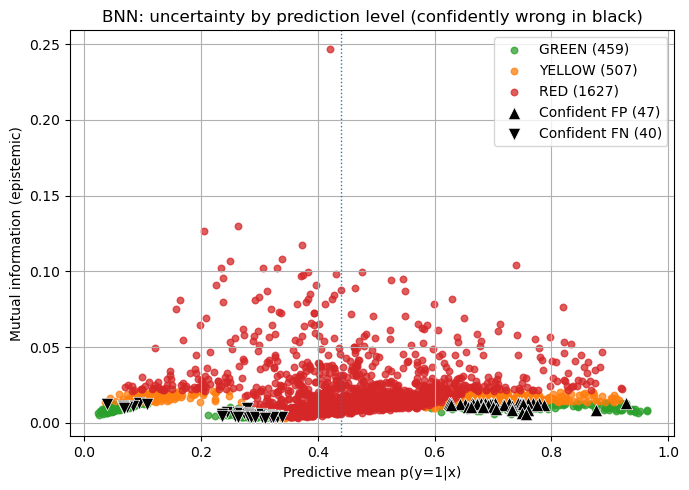

In [66]:
triage_df, triage_params = triage_uncertainty_table(
    bnn_model, X_test, y_test, thr=thr_bnn, n_samples=1000, margin_min=0.02
)
print("Traffic-light cutoffs:", triage_params)
print("\nCounts by label:")
print(triage_df["label"].value_counts())

# Confidently wrong highlight
df = triage_df.copy()
df["correct"] = (df["pred@thr"] == df["y_true"])
mask_wrong_green = (df["label"] == "GREEN") & (~df["correct"])
fp = df[mask_wrong_green & (df["pred@thr"] == 1)]
fn = df[mask_wrong_green & (df["pred@thr"] == 0)]
print(f"\nConfidently wrong (GREEN ∧ wrong): {len(fp)+len(fn)}  [FP={len(fp)}, FN={len(fn)}]")

cols = {"RED":"tab:red","YELLOW":"tab:orange","GREEN":"tab:green"}

plt.figure(figsize=(7,5))
for lab in ["GREEN","YELLOW","RED"]:
    g = df[df["label"]==lab]
    plt.scatter(g["p_mean"], g["mutual_info"], s=22, alpha=0.75,
                c=cols[lab], label=f"{lab} ({len(g)})")

# plt.scatter(fp["p_mean"], fn["mutual_info"]*0 + np.nan, alpha=0)  # keep legend order stable
plt.scatter(fp["p_mean"], fp["mutual_info"], c="k", s=80, marker="^",
            label=f"Confident FP ({len(fp)})", zorder=6, edgecolor="white", linewidths=0.5)
plt.scatter(fn["p_mean"], fn["mutual_info"], c="k", s=80, marker="v",
            label=f"Confident FN ({len(fn)})", zorder=6, edgecolor="white", linewidths=0.5)

plt.axvline(thr_bnn, linestyle=":", linewidth=1)
plt.xlabel("Predictive mean p(y=1|x)")
plt.ylabel("Mutual information (epistemic)")
plt.title("BNN: uncertainty by prediction level (confidently wrong in black)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

In [67]:
idx_max_mi = triage_df["mutual_info"].idxmax()
mi_max     = float(triage_df.loc[idx_max_mi, "mutual_info"])
p_mean_max = float(triage_df.loc[idx_max_mi, "p_mean"])

print("Max-MI index:", idx_max_mi)
print(triage_df.loc[idx_max_mi, ["p_mean","mutual_info","entropy","y_true","pred@thr","label"]])

Max-MI index: 1950
p_mean         0.421609
mutual_info    0.246919
entropy        0.680806
y_true                1
pred@thr              0
label               RED
Name: 1950, dtype: object


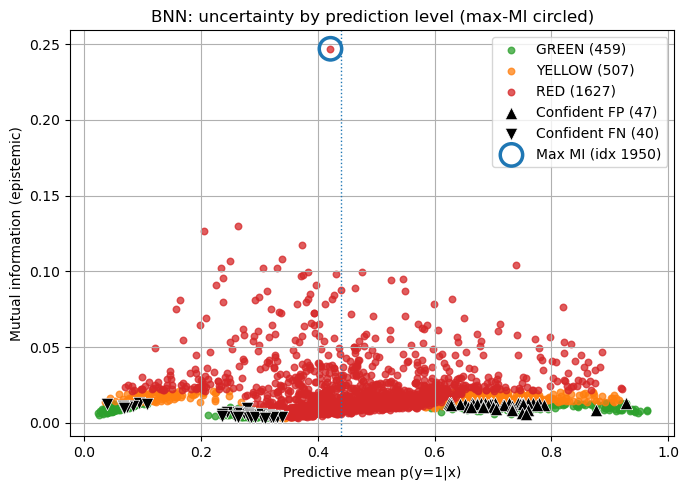

In [69]:
plt.figure(figsize=(7,5))
for lab in ["GREEN","YELLOW","RED"]:
    g = df[df["label"]==lab]
    plt.scatter(g["p_mean"], g["mutual_info"], s=22, alpha=0.75,
                c=cols[lab], label=f"{lab} ({len(g)})")

# Confidently wrong overlays
plt.scatter(fp["p_mean"], fp["mutual_info"], c="k", s=80, marker="^",
            label=f"Confident FP ({len(fp)})", zorder=6, edgecolor="white", linewidths=0.5)
plt.scatter(fn["p_mean"], fn["mutual_info"], c="k", s=80, marker="v",
            label=f"Confident FN ({len(fn)})", zorder=6, edgecolor="white", linewidths=0.5)

# 2) Blue ring around the max-MI point
plt.scatter([p_mean_max], [mi_max],
            s=260, facecolors='none', edgecolors='tab:blue',
            linewidths=2.5, zorder=8, label=f"Max MI (idx {idx_max_mi})")

plt.axvline(thr_bnn, linestyle=":", linewidth=1)
plt.xlabel("Predictive mean p(y=1|x)")
plt.ylabel("Mutual information (epistemic)")
plt.title("BNN: uncertainty by prediction level (max-MI circled)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [98]:
greens = df[df["label"] == "GREEN"]
fp     = df[(df["label"] == "GREEN") & (~df["correct"]) & (df["pred@thr"] == 1)]
fn     = df[(df["label"] == "GREEN") & (~df["correct"]) & (df["pred@thr"] == 0)]

print(f"GREEN total: {len(greens)}  |  Confidently wrong: FP={len(fp)}, FN={len(fn)}")

# Show a few rows (sorted by epistemic MI or distance to threshold)
cols_show = ["p_mean","mutual_info","entropy","dist_CI_to_thr","y_true","pred@thr"]
print("\nGREEN examples (top by MI):")
display(greens.sort_values("mutual_info", ascending=True)[cols_show].head(10))

print("\nConfident FP (top by MI):")
display(fp.sort_values("mutual_info", ascending=False)[cols_show].head(10))

print("\nConfident FN (top by MI):")
display(fn.sort_values("mutual_info", ascending=False)[cols_show].head(10))

GREEN total: 459  |  Confidently wrong: FP=47, FN=40

GREEN examples (top by MI):


,p_mean,mutual_info,entropy,dist_CI_to_thr,y_true,pred@thr
836,0.310160,0.003384,0.619229,0.057957,0,0
1055,0.286234,0.003385,0.598745,0.082272,0,0
610,0.281829,0.003403,0.594673,0.086380,0,0
1878,0.309307,0.003528,0.618545,0.055046,1,0
1027,0.321074,0.003531,0.627676,0.042115,0,0
921,0.336977,0.003591,0.639010,0.022005,0,0
1810,0.322571,0.003697,0.628792,0.041789,1,0
168,0.291076,0.003704,0.603113,0.073514,0,0
54,0.324041,0.003707,0.629878,0.039999,1,0
189,0.319452,0.003728,0.626456,0.042905,0,0



Confident FP (top by MI):


,p_mean,mutual_info,entropy,dist_CI_to_thr,y_true,pred@thr
1071,0.779198,0.013442,0.527921,0.209152,0,1
631,0.663640,0.013285,0.638592,0.073271,0,1
1689,0.767657,0.013276,0.542092,0.179118,0,1
1600,0.759037,0.013232,0.552187,0.179764,0,1
2421,0.726754,0.013217,0.586460,0.140837,0,1
2001,0.686638,0.013163,0.621765,0.094629,0,1
1616,0.745677,0.013157,0.567034,0.141932,0,1
2056,0.673002,0.013141,0.632032,0.077731,0,1
2039,0.627299,0.013100,0.660378,0.033336,0,1
2211,0.625270,0.013039,0.661425,0.035562,0,1



Confident FN (top by MI):


,p_mean,mutual_info,entropy,dist_CI_to_thr,y_true,pred@thr
2020,0.093748,0.013202,0.311125,0.225698,1,0
2004,0.039857,0.012748,0.167489,0.305285,1,0
1877,0.106693,0.012330,0.339546,0.212054,1,0
923,0.084384,0.011366,0.289348,0.251455,1,0
586,0.066436,0.011246,0.244320,0.282931,1,0
2048,0.072929,0.010796,0.261150,0.269754,1,0
987,0.066046,0.010446,0.243290,0.276211,1,0
1273,0.279486,0.009986,0.592467,0.026631,1,0
1321,0.067597,0.009563,0.247378,0.279009,1,0
1968,0.245085,0.007004,0.556870,0.088490,1,0


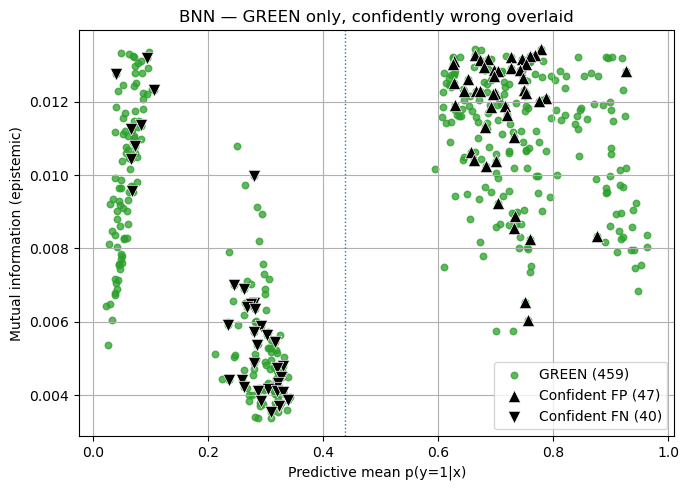

In [82]:
plt.figure(figsize=(7,5))
plt.scatter(greens["p_mean"], greens["mutual_info"], s=22, alpha=0.75,
            c="tab:green", label=f"GREEN ({len(greens)})")

plt.scatter(fp["p_mean"], fp["mutual_info"], c="k", s=80, marker="^",
            label=f"Confident FP ({len(fp)})", zorder=6, edgecolor="white", linewidths=0.5)
plt.scatter(fn["p_mean"], fn["mutual_info"], c="k", s=80, marker="v",
            label=f"Confident FN ({len(fn)})", zorder=6, edgecolor="white", linewidths=0.5)

plt.axvline(thr_bnn, linestyle=":", linewidth=1)
plt.xlabel("Predictive mean p(y=1|x)")
plt.ylabel("Mutual information (epistemic)")
plt.title("BNN — GREEN only, confidently wrong overlaid")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

In [83]:
# Counts of GREEN predictions by class (based on mean vs threshold)
green_counts = greens["pred@thr"].value_counts().rename(index={0:"pred=0", 1:"pred=1"})
green_props  = greens["pred@thr"].value_counts(normalize=True).rename(index={0:"pred=0", 1:"pred=1"})

print(f"GREEN total = {len(greens)}")
print("GREEN prediction counts:")
print(green_counts.to_string())
print("\nGREEN prediction proportions:")
print((green_props*100).round(2).astype(str) + "%")

GREEN total = 459
GREEN prediction counts:
pred@thr
pred=1    243
pred=0    216

GREEN prediction proportions:
pred@thr
pred=1    52.94%
pred=0    47.06%
Name: proportion, dtype: object
